In [2]:
# My goal here is to import every library I'd possibly need. (Describe each library)
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import itertools
from bs4 import BeautifulSoup
import requests
import time
%matplotlib inline

# Project

Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry.

Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

#### Takeaways

- client Microsoft: interest in creating movies, need help understanding the movie industry
- data analysis / presentation exploring types of films doing well at the box office
- translate findings into actionable insights for types of films they should be creating

#### Proposed Questions to Answer with Data Set and Proposed Graphic

1. Which genre should we choose to get the most global reach? Which do people seem to like (ratings)? Which genre has seen the greatest increase in median domestic/foreign gross?

    - Genre Histogram [2010-2020] 
    - Gross (y) vs. genre (x) barchart [2010-2020] (+ stddev error bars)
    - Median Percent Increase Time Series [2010-2020] (median of top 3 genres)
    - Avg Ratings vs. Revenue Scatterplot (correlation of top 3 genre)
    

2. Which director/producer demonstrates the best projected success (revenue consistency  growth) to lead us through this transition?

    - Revenue (y) vs. Top 10 Directors Boxplot
    - Top 10 Director Gross Income vs. Movie Number 
    

3. Are there seasonal trends that would suggest when we should release movies or what genres we should focus on in each season to maximize profit? Can we distribute year round or double down on a certain season?
    
    - Top 3 Genre Gross Revenue vs. Season barchart (+ stddev error bars)

#### Resources I Will Use

- IMDb (general movie info) [IMDb]
- Box Office Mojo (movie financial info) [BOM]

#### Information I Need [Source]

- Unique Move Identifier (Title Code) [IMDb]
- Movie Title [IMDb]
- Director(s) [IMDb]
- Genre Collection [IMDb]
- Genre[IMDb]
- Rating [IMDb]
- Release Year [IMDb]
- Release Season [calc] = Month Release [BOM]
- Domestic & Foreign Gross (which genre has seen the biggest increase in foreign gross
- WorldwideRevenue [calc] = (WorldWide Gross [BOM] - Budget [BOM])


#### Assumptions / Limitations

Our primary marker for success is ($$), which is why we absolutely need the information from Box Office Mojo. Though ratings may be a proxy for profit, especially over the lifetime of the movie, we will focus on the money made on a film as the primary. Time permitting, we will explore the relationship between ratings and money made after opening day(domestic gross -domestic opening). The reality is the rating is subjective regardless of the suggested guidelines (i.e. https://www.imdb.com/list/ls022463589/). Plus...you've already paid for the movie, so...the box office has won. In the future, however, it might be worth tracking the money made throughout entire franchise (merchandise, IP, games, sequels, etc.) as the ratings may be an indication of what people are likely to continue to financially support. The true Data Science mind thinks about how the data gathered will influence the next instance.

Choosing the year 2010 as the earliest year we look at because it marks the point where companies decided to capitalize on the business opportunity presented by the maturation of technology (chip, screen manfacturing, camera technology, cloud architecture) to diversify their content offerings (i.e. Netflix, Hulu, HD/4K). So the year range will be 2010-2019.

Choosing to collect information on movies "worth watching', which I classifying as movies with 10,000 or more votes. Are more highly rated movies voted on more? That is a question to answer through another study. However, Microsoft' interest is in mimicking movies with a lot of clout...which means people are talking them and sharing their opinions on them. So we're only looking at movies that have garnered enough interest (>10,000 votes).

Choosing IMBD/BoxMojo (owned by amazon) because it offers a fairly transparent, open database of information. Comparing across multiple databases would be better for future studies, especially if we want to explore the correlation of ratings with gross profit over lifetime of movie (i.e. Fandango's Rotten Tomatoes, Metacritic, themoviedb.org, Criticker, etc.)

Choosing to use foreign gross as opposed to other individual country grosses for simplicity. The goal is to identify what type movies do well outside of the domestic region as well. The genre preferences for the regions whose movie market have grown the most will represent a significant enough portion to determine the genre-specific market share opportunity.

My inital database of titles is based on the information provided in a static set of files from IMDb's website. Though the option of scraping everything creates the opportunity and framework to get the most up to date information, I decided to only scrape for what I needed for simplicity, constrained by time constraints and depth of understanding. However, scraping architecture often needs to be updated as often as the website you're scraping from, including renewed permission/licenses where necessary. Things to keep in mind for future studies.

## Workflow

1. Download/explore IMBD datasets provided on (https://datasets.imdbws.com). Documentation available (https://www.imdb.com/interfaces/). Extract necessary information from each file to building dataframe final_IMDB_df. 

    - **Unique Move Identifier (Title Code)**
    - **Movie Title**
    - **Director(s)**
    - **Genre**
    - **AvgRating** (with above 100,000 votes)
    - **Release Year** (2010-2019)
    

2. Use unique movie identifer to scrape rest of info from BOM (https://www.boxofficemojo.com/title/) into necessary dataframes, then combine to final_BOM_df.

    - **Budget**
    - "Earliest Release Date" --> Month --> **Release Season**
    - **Domestic/International/Worldwide Gross** (3 different columns)
    - **Revenue** (Worldwide - Budget)
    
    

3. Combine data from IMDb inital datset and BOM scraping into MasterMovie_df. 


4. Subset dataframes for data analysis and plots.


5. Plot. Make the plots sexy...aka not terribly hard to read. (*I'll work on beautifying plots another time* Analyze/Provide insights based on revealed trends. Copy paste into presentation.


6. Finish presentation with good ordering or information, supporting pictures, minimal words, and non-distracting themes. Annotate / Script. Record. BOOM! 2 birds...one YUGE stone.


7. Blog...


8. Git Add . , Git Commit -M "Final ____ ", Git Push it real good.  

## IMDb Dataset Manipulation

From the looking at the documentation for the IMDb dataset, we can preview the information available in each csv with loading all of them. After inspection we will use the following files for our EDA (important columns of dataset): 

- title.basics.tsv.gz (tconst, titleType, primaryTitle, startYear, genres *[string array**]*)
- title.crew.tsv (tconst, nconst)
- names.basics.tsv (nconst, primaryName)
- title.ratings.tsv (tconst, averageRating)

    ***Python doesn't actually have support for string arrays. If it did, might have allowed us access that format without futher manipulation. However, what we might be able to do is access the string array as an object or unique identifier for every movie with the same multi-classification.*

In [2]:
# ## Use pandas library to read csv in as a Dataframe. 

# name_basics_df = pd.read_csv('IMDb_new_tsvs/name.basics.tsv', delimiter ='\t', encoding='UTF-8', low_memory = False)
# title_basics_df = pd.read_csv('IMDb_new_tsvs/title.basics.tsv', delimiter ='\t', encoding='UTF-8', low_memory = False)
# title_crew_df = pd.read_csv('IMDb_new_tsvs/title.crew.tsv', delimiter ='\t', encoding='UTF-8', low_memory=False)
# title_ratings_df = pd.read_csv('IMDb_new_tsvs/title.ratings.tsv', delimiter ='\t', encoding='UTF-8',low_memory=False)

In [3]:
# ## Note, as I go through each dataframe and extract information, I won't make changes to
# ## the original dataframe, so that if any mistakes are made I can always reference them.

# ## Preview one of the instances to make sure we successfully converted it into a DataFrame
# title_basics_df.head()

In [4]:
# ## Preview the types of information in each DataFrame
# dfs = [name_basics_df, title_basics_df, title_crew_df, title_ratings_df]
# for i in dfs:
#     print(i.info())

In [5]:
# ## The base dataframe we want to use is the one with all of the basic title information.
# ## We want to be able to narrow down the entries we check by the type: movie.
# ## Let's first see how many we're looking for.
# title_basics_df.titleType.value_counts() 

In [6]:
# ## Looks like we're looking looking for 548,820 entries out of the 6 million.
# ## So let's make an empty list to put all of the information we want into.
# movie_list = []
# ## Let's also intialize a counter to check to make sure our loop works.
# count = 0
# ## Goal is to loop and if the titleType is a movie store the [tconst,primaryTitle, startYear, genres]. 
# for x in list(range(0,len(title_basics_df))):
#     if title_basics_df['titleType'][x] == 'movie':
#         movie_list.append([title_basics_df['tconst'][x], 
#                            title_basics_df['primaryTitle'][x], 
#                            title_basics_df['startYear'][x], 
#                            title_basics_df['genres'][x]])
#         count += 1 ## advance counter each time it finds a movie
# print(len(movie_list))
# print(count) ## ensures we recorded the correct number of movies compared to the value_counts()

In [7]:
# ## With all of the information we want in our list, let's make a dataframe.
# movie_df = pd.DataFrame(movie_list, columns = ['tconst','movieTitle','releaseYear','genreString'])
# movie_df.head()

In [8]:
# movie_df.info()

In [9]:
# ## Let's take a look at what value counts are in section.
# ## Because though there may be non-null objects in every cell,
# ## IMDb labels their null info with '\\N' instead.
# for x in movie_df.columns:
#     print(movie_df[x].value_counts())

Seems our dataframe has plenty of '\\N' values associated with both the release year and genre columns. Because we will have plenty of data points and don't want to ruin the integrity of each entry, we will remove all entries with no information ('\\N') at this time. We want the analysis we do to be only based on titles with full sets of information available.

In [10]:
# ## Let's address the releaseYear info first. 
# movie_df.releaseYear.value_counts()

In [11]:
# ## We will make it so that we only keep those without '\\N'.
# movie_df = movie_df[movie_df['releaseYear'] != '\\N']
# movie_df

In [12]:
# ## Sweet, now let's address the genreString info next.
# movie_df.genreString.value_counts()

In [13]:
# ## Some are gone, but let's again, keep only those without '\\N'.
# movie_df = movie_df[movie_df['genreString'] != '\\N']
# movie_df

In [14]:
# ## Now let's see what info is included.
# for x in movie_df.columns:
#     print(movie_df[x].value_counts())

In [15]:
# ## Sweet, now let's see if we can get to the years of interest, 2010-2019.
# ## First we know that the date is an object with the info from before. 
# ## So let's convert it to a string first then and integer using dataframe methods. 
# movie_df.loc[:,'releaseYear'] = movie_df.loc[:,'releaseYear'].astype(str).astype(int)

In [16]:
# ## Now let's keep only those >= 2010 and <=2019
# movie_df = movie_df[(movie_df['releaseYear'] >= 2010) & (movie_df['releaseYear'] <= 2019)] 
# movie_df.head()

In [17]:
# ## Let's make sure 
# movie_df.releaseYear.value_counts()

In [18]:
# ## Sweet, let's make set the index to the tconst, since it's unique to each dstinct
# ## distinct title and common amon the rest of our dataframes.
# movie_df = movie_df.set_index('tconst')
# movie_df

In [19]:
# ## Cool so let's recast our movie_df into base_movie_df,
# ## so we can always come back to the movie_df if need be.
# base_movie_df = movie_df
# ## Then let's merge it with the title_ratings_df on the tconst.
# ratings_movie_df = base_movie_df.merge(title_ratings_df, on = 'tconst')
# ratings_movie_df

In [20]:
# print(ratings_movie_df.info())
# print(ratings_movie_df.averageRating.value_counts())
# print(ratings_movie_df.numVotes.value_counts())

Though I wanted to narrow down the list by number of votes, I do not know with certainty that the number of votes on the IMDb platform correlates, in a reliable way, with the profits a movie makes. I could inadvertly miss movies that peoeple loved and paid for but decided not to vote on for whatever reason (i.e. inconvenience, lack of platform awareness of platform, interest in sharing opinion, time, etc.). However, the code below shows how the list could be narrowed down further to a top 100 list of sorts, but for votes, instead of money. If there is a proper, reliable correlation between # of votes and the financials, then a model including #votes and rating could be devised to predict predict the most successful movies of the year and their financials, even the absence of such info.

In [21]:
# ratings_movie_df[(ratings_movie_df['numVotes'] >= 50000)& (ratings_movie_df['releaseYear'] == 2014)]

For now we'll keep all of the columns and data and from ratings so we can use it later and find out. But another reason to potential narrow things down using the numVotes is so that we don't call the server 80k time when we scraping financial info. However, the professional thing to do is try first and seek out another solution if we run into that problem, which we happen to have an idea on.

In [22]:
# ## Next let's again set the index and merge on the tconst for the crew.
# ## We'll do this to get the unique identifier for each director 'nconst'. 
# ## We'll also set this equal to a new finalized dataframe.
# final_ratings_movie_df = ratings_movie_df.set_index('tconst')
# final_ratings_movie_df

In [23]:
# ## Sweet now let's merge the the crew.
# crew_ratings_movie_df = final_ratings_movie_df.merge(title_crew_df, on = 'tconst')
# crew_ratings_movie_df 

In [24]:
# print(crew_ratings_movie_df.info())
# print(crew_ratings_movie_df.directors.value_counts())
# print(crew_ratings_movie_df.writers.value_counts())

For this study, we are focusing on the directors involved as their contributions (along with the producers) will allow them to recruit the best writers and actors associated with a film. So we are going to drop the writers column. Additonally, because having information on the directors is a pretty important part of our study, we're going to remove all of the entries with no director information. (also it's only less than 1% missing, view with value_counts(normalize=True) is interested)

In [25]:
# # Drop writers column
# crew_ratings_movie_df = crew_ratings_movie_df.drop(columns=['writers'])
# crew_ratings_movie_df

In [26]:
# # Only keep director columns without '\\N'
# crew_ratings_movie_df = crew_ratings_movie_df[crew_ratings_movie_df['directors'] != '\\N']
# print(crew_ratings_movie_df.directors.value_counts())
# crew_ratings_movie_df

In [27]:
# # crew_ratings_movie_df.genreString.value_counts(normalize=True).head(25)
# # genreString_list = list(crew_ratings_movie_df.genreString.unique())
# # genreString_list.sort()
# # print(genreString_list)
# crew_ratings_movie_df = crew_ratings_movie_df.set_index('tconst')
# crew_ratings_movie_df.head(25)

In [28]:
# multi_dir_list = []
# count = 0
# for x in list(range(0,len(crew_ratings_movie_df))):
#     if ',' in crew_ratings_movie_df['directors'][x]:
#         multi_dir_list.append(crew_ratings_movie_df['directors'][x])
#         count += 1
# print(count)

In [29]:
# two_dir_list = []
# three_dir_list = []
# four_plus_dir_list = []
# for x in multi_dir_list:
#     if len(x) < 20:
#         two_dir_list.append(x)
#     elif len(x) < 30:
#         three_dir_list.append(x)
#     else:
#         four_plus_dir_list.append(x)
# print(len(two_dir_list))
# print(len(three_dir_list))
# print(len(four_plus_dir_list))

In [30]:
# ## We have 9040 movies with multiple directors. If we simply merge on the nconst, 
# ## it will get rid of all the movies with multiple directors. Removing movies just
# ## because they have multiple directors isn't fair, so...we'll find another way.
# dummy_df = crew_ratings_movie_df
# dummy_df = dummy_df.rename(columns={'directors':'nconst'})
# ddummy_df.merge(name_basics_df, on = 'nconst')

In [31]:
# ## We see that all director entries are strings, even the ones with multiple.
# type(crew_ratings_movie_df['directors'][3])

In [32]:
# ## So what we can do is split the names into a list using the lambda function.
# crew_ratings_movie_df['directors'] = crew_ratings_movie_df['directors'].map(lambda text: text.split(','))
# crew_ratings_movie_df 

In [33]:
# ## rename the directors column to match the unique id column of the merging column...
# ## unnecessary,since we're going to do this different but matches what info is being shown.
# crew_ratings_movie_df = crew_ratings_movie_df.rename(columns={'directors':'nconst'})
# crew_ratings_movie_df

In [34]:
# crew_ratings_movie_df.at['tt0016906','movieTitle']

In [35]:
# ## First set index of name_basics_df so it's easier to traverse equal to new dataframe.
# nam_d = name_basics_df.set_index('nconst')
# nam_d.head()

In [36]:
# # This is how to extract a single piece of info from new dataframe using an nconst. 
# dummy = 'nm3754088'
# # dummy = crew_ratings_movie_df['nconst'][3]
# # for item in dummy:
# #     print(nam_d.at[item,'primaryName'])
# dummy in crew_ratings_movie_df.values
# # nam_d.at[dummy,'primaryName']

In [37]:
# ## Create a shortlist of directors to look for from the name_basic_df
# existing_dir_list = []
# count = 0
# for x in list(range(0,len(crew_ratings_movie_df))):
#     for item in crew_ratings_movie_df['nconst'][x]:
#         if item in existing_dir_list:
#             continue
#         else:
#             existing_dir_list.append(item)
#             count += 1
# print(count)
# print(len(existing_dir_list))
    

In [38]:
# ## Create small dataframe of the director shortlist to merge with name_basic_df
# short_dir_df = pd.DataFrame(existing_dir_list, columns = ['nconst'])
# short_dir_df = short_dir_df.set_index('nconst')
# short_dir_df.head()

In [39]:
# ## Merge short_dir_df with name_basic_df
# movie_dir_df = short_dir_df.merge(name_basics_df, on = 'nconst')
# movie_dir_df

In [40]:
# ## Solid. Let's get rid of the people who have passed, because they can't help Microsoft.
# movie_dir_df = movie_dir_df[movie_dir_df['deathYear'] == '\\N']
# movie_dir_df

In [41]:
# ## drop the parts of the dataframe you no longer need
# movie_dir_df = movie_dir_df.drop(columns = ['birthYear', 'deathYear','primaryProfession','knownForTitles'])
# movie_dir_df

In [42]:
# # Use a for loop to go through each entry in our dataframe and match it
# # with the entry from the movie_dir_df. Append the name list to a movie_dir_list.
# # Since we know it will be the right order, we don't need to worry about matching the
# # movie title ID, since we'll just concatenate the frames after setting the index.
# movie_dir_list = []
# count = 0
# for x in list(range(0,len(crew_ratings_movie_df))):
#     specific_dir_list = []
#     for item in crew_ratings_movie_df['nconst'][x]:
#         if item not in movie_dir_df.values:
#             count += 1
# #             specific_dir_list.append(movie_dir_df.at[item,'primaryName'])
#         else:
#             continue
#     movie_dir_list.append(specific_dir_list)
# print(len(movie_dir_list))
# print(count)

So far, I've found that it's taking too long to get through this line of code. What I can also do is just hang on to the file and use it once I have a particular list of movies where based on their success, we want to know the directors. So we're going to move on by keeping both our crew_ratings_movie_df and the short list of movie directors names and save them to csv files that we can refer to later that represent movies from 2010-2019 and living directors that worked on them.

In [43]:
# # final_movie_dir_df = pd.DataFrame(movie_dir_list, columns = ['directorName'])
# # final_movie_dir_df.head()
# movie_info_2010_2019_df = crew_ratings_movie_df.reset_index()
# director_info_2010_2019_df = movie_dir_df
    

In [44]:
# movie_info_2010_2019_df

In [45]:
# director_info_2010_2019_df

In [46]:
# ls

In [47]:
# movie_info_2010_2019_df.to_csv('IMDb_movie_info_2010_2019.csv', sep='\t', encoding='utf-8')
# director_info_2010_2019_df.to_csv('IMDb_director_info_2010_2019.csv', sep='\t', encoding='utf-8')

In [48]:
# ls

## Box Office Mojo Scraping

We'll by reloading what we saved from our 2010-2019 IMDb dataframe so we can add the financial stuff to it.

In [2]:
ls

Building Notebook.ipynb           README.md
CONTRIBUTING.md                   Scraping Notebook.ipynb
Dummy Notebook.ipynb              awesome.gif
IMBd TSV Work.ipynb               module1_project_rubric.pdf
IMDb_director_info_2010_2019.csv  movielens dataset-25m/
IMDb_movie_info_2010_2019.csv     student.ipynb
IMDb_new_tsvs/                    unzippedData/
LICENSE.md                        zippedData/


In [2]:
# movie_basics_df = pd.read_csv('IMDb_movie_info_2010_2019.csv', delimiter ='\t', encoding='UTF-8', low_memory = False)
# movie_basics_df.head()

In [3]:
# ## Forgot to drop index, so let's drop the Unnamed column
# movie_basics_df = movie_basics_df.drop(columns = 'Unnamed: 0')
# movie_basics_df.head()

Sweet. So to this dataframe we'll to add financial information from Box Office Mojo. The goal is the use the tconst (our title ID) from each movie to access their info on Box Office Mojo. Now let' scrape.

But wait... what I've learned about scraping is that if you do it too fast, your IP can be banned or it could take a really long time if you're scraping for a lot of data. The solutions I've seen are to add a time.sleep() step so you don't pull data too fast, use another website, or choose a more sophisticated scraper like Selenium (https://towardsdatascience.com/in-10-minutes-web-scraping-with-beautiful-soup-and-selenium-for-data-professionals-8de169d36319). 


However, what I will do instead of scraping 80k pages is scrape the 10 pages that have at least the minimal financial infomration I need for the worldwide movies each year between 2010 and 2019, first. 

In [5]:
# def topWorldwide_bom_scrape(year):
#     response = requests.get('https://www.boxofficemojo.com/year/world/' + str(year)) #request site by appending titleID
#     soup = BeautifulSoup(response.content, 'html.parser') ## BS tool args are your request, and the parser package
#     profile = soup.find('div', class_="a-section imdb-scroll-table-inner") #use info found by inspection
#     narrowDown = profile.findAll('tr')[1:] ## narrow what part of table you want
#     rows = []
#     for entry in narrowDown:
#         movie = entry.findAll('td')[1].text
#         worldwide_gross = int(entry.findAll('td')[2].text.replace('$','').replace(',',''))
#         if entry.findAll('td')[3].text == '-':
#             domestic_gross = 0
#         else:
#             domestic_gross = int(entry.findAll('td')[3].text.replace('$','').replace(',',''))
#         rows.append([movie, worldwide_gross, domestic_gross, year])
#     return rows

In [4]:
# topWorldwide_bom_scrape(2010)

In [5]:
# topWorldwide_movies_list = []
# for x in range(2010,2020):
#     topWorldwide_movies_list += topWorldwide_bom_scrape(x)
# print(len(topWorldwide_movies_list))

In [6]:
# topWorldwide_movies_df = pd.DataFrame(topWorldwide_movies_list, columns = ['movieTitle','worldwide_gross','domestic_gross','releaseYear'])
# topWorldwide_movies_df.head()

In [7]:
# ## Now let's create the international gross column using dataframe operations.
# topWorldwide_movies_df['foreign_gross'] = topWorldwide_movies_df['worldwide_gross'] - topWorldwide_movies_df['domestic_gross']
# topWorldwide_movies_df

In [9]:
# topWorldwide_movies_df.info()

In [8]:
# topWorldwide_movies_df.movieTitle.value_counts()

In [10]:
# topWorldwide_movies_df[topWorldwide_movies_df.duplicated(['movieTitle'])]

In [11]:
# movie_basics_df[movie_basics_df.duplicated('movieTitle')]

In [12]:

# dummy_movie_df = movie_basics_df.set_index('movieTitle')
# dummy_movie_df.head()

In [13]:
# dummy_movie_df.releaseYear.value_counts()

In [14]:
# dummy_worldwide_df = topWorldwide_movies_df.set_index('movieTitle')
# dummy_worldwide_df.head()

In [15]:
# dummy_worldwide_df.releaseYear.value_counts()

In [16]:
## Let's merge these dataframes on movieTitle and releaseYear, which is the only way we can
# ## tie these pieces of info to each other without scraping each individual page. However,
# ## this may lead to duplicateds with inaccurate information.
# worldwide_first = dummy_worldwide_df.merge(dummy_movie_df, on=['movieTitle', 'releaseYear'])
# worldwide_first.head()

Uh oh...looks like we have duplicates.

In [17]:
# worldwide_df = worldwide_first.reset_index()

In [18]:
# ##Officially check for duplicates
# worldwide_df[worldwide_df.duplicated(['movieTitle'])]

In [19]:
# ## Since we have duplicates (e.g. Alice in Wonderland, our only option is to exclude all info with duplicate
# ## titles from the dataframe, as there is no way to tell with the based on the title
# ## that the financial information matches that of the duplicate.
# # dropping ALL duplicte values 
# worldwide_df.drop_duplicates(subset ="movieTitle", keep = False, inplace = True)
# worldwide_df.head()

In [20]:
# ## Check to make sure we're removed all duplicates
# worldwide_df[worldwide_df.duplicated(['movieTitle'])]

In [81]:
# worldwide_df.set_index('tconst', inplace =True)

In [21]:
# worldwide_df.reset_index(inplace = True)
# worldwide_df

Last thing we'll try to do is access date and budget information for the movies. If this is possible, then it might be worth trying to scrape all the information for the same place to preserve validity.

In [28]:
# def bom_scrape_budget_month(tconst):
#     response = requests.get('https://www.boxofficemojo.com/title/' + tconst) #request site by appending titleID
#     soup = BeautifulSoup(response.content, 'html.parser') ## BS tool args are your request, and the parser package
#     profile1 = soup.find('div', class_="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile") #use info found by inspection
#     narrowDown_budget = profile1.findAll('span', class_='money')
#     budget = int(narrowDown_budget[1].text.replace('$','').replace(',',''))
#     profile2 = soup.find('div', class_="a-section mojo-h-scroll")
#     narrowDown_releaseDate = profile2.findAll('td')
#     releaseMonth = narrowDown_releaseDate[1].text.split()[0]
    
#     budget_month = [tconst, budget, releaseMonth]
    
#     return budget_month

In [27]:
# dummy_budget_month_list = bom_scrape_budget_month('tt0435761')
# dummy_budget_month_list

In [236]:
# General code needed for the data we're looking for is below:

# def bom_scrape_financials(tconst):
#     response = requests.get('https://www.boxofficemojo.com/title/' + tconst) #request site by appending titleID
#     soup = BeautifulSoup(response.content, 'html.parser') ## BS tool args are your request, and the parser package
    
#     profile2 = soup.find('div', class_="a-section mojo-h-scroll")
#     narrowDown_releaseDate = profile2.findAll('td')
#     if narrowDown_releaseDate:
#         releaseMonth = narrowDown_releaseDate[1].text.split()[0]
#     else:
#         releaseMonth = '\\N'
    
#     profile = soup.find('div', class_="a-section a-spacing-none mojo-performance-summary-table") #use info found by inspection
#     narrowDown = profile.findAll('span', class_='a-size-medium a-text-bold')
#     gross_dict = {0: '\\N', 1: '\\N', 2: '\\N'}
#     for x in range(0, len(narrowDown)):
#         text = narrowDown[x].text.strip()
#         if text == '–':
#             continue
#         else:
#             gross_dict[x] = int(text.replace('$','').replace(',',''))
    
#     rows = [tconst, gross_dict[0], gross_dict[1], gross_dict[2], releaseMonth]
#     return rows

In [29]:
# ## Proof of concept on single item
# bom_scrape_financials('tt0914863')
# # bad Boys --> tt1502397
# # start_time = time.time()
# # print("--- %s seconds ---" % (time.time() - start_time))

In [30]:
# ## Proof of concept on a couple itmes
# dummy = ['tt0359950', 'tt0365907','tt0369610']
# dummy_financials = []
# for item in dummy:
#     dummy_financials.append(bom_scrape_financials(item))
# print(dummy_financials)
# dummy_df = pd.DataFrame(dummy_financials, columns = ['tconst','Domestic','International','Worldwide','releaseMonth'])
# dummy_df

In [31]:
# ## Proof of concept from dataframe
# new_dummy_financials = []
# for item in dummy_df.tconst[:5]:
#     new_dummy_financials.append(bom_scrape_financials(item))
# print(new_dummy_financials)


In [32]:
# ## Let's try this on movies that have more than 50k votes on 
# top50kV_movies_df = movie_basics_df[(movie_basics_df['numVotes'] >= 50000)].set_index('tconst')
# top50kV_movies_df.reset_index(inplace=True)
# top50kV_movies_df

In [33]:
# top50kV_movies_df.iloc[90]

In [34]:
# scraping_list =[]
# count = 0
# for item in top50kV_movies_df.tconst[1179:]:
#     scraping_list.append(bom_scrape_financials(item))
#     count += 1
# print(len(scraping_list))

In [35]:
# print(count)
# top50kV_financials_list = top50kV_financials_list + scraping_list
# print(len(top50kV_financials_list))

In [36]:
# ## Of the 1180 entries, with a little stop an go, we were able to retrieve 1162 of them.
# ## We'll take it. Took quite a bit.
# top50kV_financials_df = pd.DataFrame(top50kV_financials_list, columns= ['tconst','Domestic','International','Worldwide','releaseMonth'])
# top50kV_financials_df.head()

In [37]:
# ## Now lets combine merge this with our movie_basics_df on the unique tconst ID.
# top50kV_financials_df.set_index('tconst', inplace=True)
# combining_movie_df = movie_basics_df.set_index('tconst')
# almost_final_50kV_df= top50kV_financials_df.merge(combining_movie_df, on='tconst')
# almost_final_50kV_df

In [38]:
# for column in almost_final_50kV_df.columns:
#     print(almost_final_50kV_df[column].value_counts())

In [39]:
# ## Let's deal with the missing values generated (in the domestic, international, worldwide columns.
# almost_final_50kV_df[(almost_final_50kV_df['Domestic'] == '\\N') & (almost_final_50kV_df['International'] == '\\N')]


In [40]:
# ## Drop tt2388771, tt2737304, tt6412452
# almost_final_50kV_df.drop(['tt2388771', 'tt2737304', 'tt6412452'], inplace = True)

In [41]:
# ## For the international values, just replace them with 0. 
# almost_final_50kV_df[(almost_final_50kV_df['International'] == '\\N')]

In [42]:
# almost_final_50kV_df.at['tt1365050','International'] = 0
# almost_final_50kV_df.at['tt2051879','International'] = 0
# almost_final_50kV_df.at['tt2452244','International'] = 0
# almost_final_50kV_df.at['tt5727208','International'] = 0

In [43]:
# almost_final_50kV_df[(almost_final_50kV_df['International'] == '\\N')]

In [44]:
# ## Finally let's update the Domestic perhaps by creating a new 
# almost_final_50kV_df['Domestic'] = almost_final_50kV_df['Worldwide'] - almost_final_50kV_df['International']

In [45]:
# almost_final_50kV_df[(almost_final_50kV_df['International'] == '\\N')]

In [46]:
# ## Last but not least, let's conver the releaseMonth to releaseSeason
# def convert_word_seasons(months_list):
#     word_season_dict = {'Dec':'Winter','Jan':'Winter',
#                         'Feb':'Winter','Mar':'Spring',
#                         'Apr':'Spring', 'May':'Spring',
#                         'Jun':'Summer','Jul':'Summer',
#                         'Aug':'Summer','Sep':'Fall',
#                         'Oct':'Fall','Nov':'Fall',
#                         'December':'Winter','January':'Winter',
#                         'February':'Winter','March':'Spring',
#                         'April':'Spring',
#                         'June':'Summer','July':'Summer',
#                         'August':'Summer','September':'Fall',
#                         'October':'Fall','November':'Fall'}
    
#     converted = []
#     for month in months_list:
#         converted.append(word_season_dict.get(month))
#     df = pd.DataFrame(converted, columns = ['releaseSeason'])
#     return df


In [47]:
# releaseMonth_list = []
# for month in almost_final_50kV_df.releaseMonth:
#     releaseMonth_list.append(month)
# print(len(releaseMonth_list))
# releaseSeason_df = convert_word_seasons(releaseMonth_list)
# releaseSeason_df


In [350]:
# almost_final_50kV_df.reset_index(inplace = True)

In [360]:
# final_df = almost_final_50kV_df.join(releaseSeason_df)

In [48]:
# ## This final dataframe will be used alongside the directors dataframe
# ## to grab subsets of data for plotting. We will write it to a csv so it
# ## can be used for future operations.
# final_df.to_csv('IMDb_2010_19_top50kVotes_w_financials.csv', sep='\t', encoding='utf-8')

In [50]:
ls

Building Notebook.ipynb
CONTRIBUTING.md
Dummy Notebook.ipynb
IMBd TSV Work.ipynb
IMDb_2010_19_top50kVotes_w_financials.csv
IMDb_director_info_2010_2019.csv
IMDb_movie_info_2010_2019.csv
IMDb_new_tsvs/
LICENSE.md
README.md
Scraping Notebook.ipynb
awesome.gif
module1_project_rubric.pdf
movielens dataset-25m/
student.ipynb
unzippedData/
zippedData/


## Master Movie Dataframe + Sub-dataframes + Plots

In [3]:
## import csv files
movie_master_df = pd.read_csv('IMDb_2010_19_top50kVotes_w_financials.csv', 
                              delimiter ='\t', encoding='UTF-8', low_memory = False)
director_master_df = pd.read_csv('IMDb_director_info_2010_2019.csv', 
                              delimiter ='\t', encoding='UTF-8', low_memory = False)

In [4]:
movie_master_df.drop(columns = 'Unnamed: 0', inplace = True)
movie_master_df.head()

,tconst,Domestic,International,Worldwide,releaseMonth,movieTitle,releaseYear,genreString,averageRating,numVotes,nconst,releaseSeason
0,tt0359950,58236838,129896484,188133322,Dec,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,284466,['nm0001774'],Winter
1,tt0365907,26307600,32526784,58834384,Sep,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,109104,['nm0291082'],Fall
2,tt0369610,652270625,1018130012,1670400637,Jun,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,560294,['nm1119880'],Summer
3,tt0376136,13109815,17025143,30134958,Oct,The Rum Diary,2011,"Comedy,Drama",6.2,96913,['nm0732430'],Fall
4,tt0377981,99967670,94000000,193967670,Feb,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,50968,['nm0038432'],Winter


In [178]:
movie_master_df.describe()

,Domestic,International,Worldwide,releaseYear,averageRating,numVotes
count,1.159000e+03,1.159000e+03,1.159000e+03,1159.000000,1159.000000,1.159000e+03
mean,7.956623e+07,1.307309e+08,2.102971e+08,2013.907679,6.742709,1.873118e+05
std,1.047624e+08,1.937175e+08,2.897143e+08,2.696688,0.865066,1.808273e+05
min,0.000000e+00,0.000000e+00,1.541000e+03,2010.000000,1.400000,5.008000e+04
25%,1.502505e+07,1.660770e+07,3.564799e+07,2012.000000,6.200000,7.677000e+04
50%,4.493654e+07,5.259821e+07,1.000140e+08,2014.000000,6.800000,1.191980e+05
75%,1.019030e+08,1.632566e+08,2.547018e+08,2016.000000,7.300000,2.224655e+05
max,9.366622e+08,1.939428e+09,2.797801e+09,2019.000000,8.900000,1.950039e+06


In [5]:
director_master_df.drop(columns = 'Unnamed: 0',inplace=True)
director_master_df.head()

,nconst,primaryName
0,nm0136068,Arturo Carballo
1,nm0863604,Bassori Timite
2,nm0765384,Valeria Sarmiento
3,nm6883878,Mc Jones
4,nm0007037,John Bailey


- Genre Histogram [2010-2020] 
- Gross (y) vs. genre (x) barchart [2010-2020] (+ stddev error bars)
- Median Percent Increase Time Series [2010-2020] (median of top 3 genres)
- Avg Ratings vs. Revenue Scatterplot (correlation of top 3 genre

In [6]:
len(movie_master_df.genreString.value_counts())

185

In [7]:
## Genre Histogram Data
genre_hist_df = movie_master_df.genreString.value_counts().rename_axis('Genres').reset_index(name='counts')
genre_hist_df.head()

,Genres,counts
0,"Action,Adventure,Sci-Fi",70
1,"Adventure,Animation,Comedy",46
2,"Comedy,Drama,Romance",45
3,"Action,Adventure,Fantasy",36
4,Comedy,36


In [11]:
top20genre = genre_hist_df.iloc[:20]
top20genre 

,Genres,counts
0,"Action,Adventure,Sci-Fi",70
1,"Adventure,Animation,Comedy",46
2,"Comedy,Drama,Romance",45
3,"Action,Adventure,Fantasy",36
4,Comedy,36
5,"Action,Adventure,Comedy",32
6,"Comedy,Drama",32
7,"Action,Crime,Drama",30
8,"Horror,Mystery,Thriller",28
9,"Drama,Romance",28


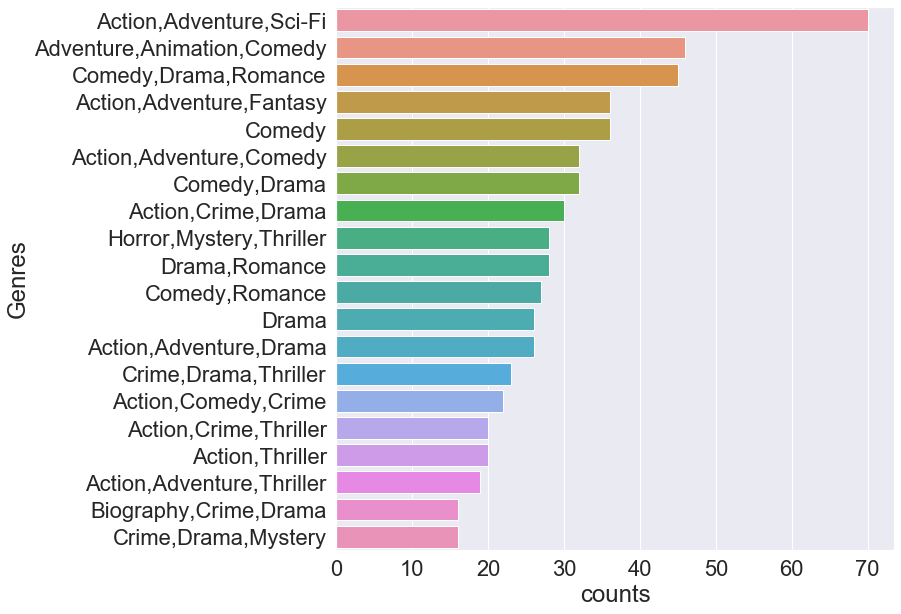

In [12]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.barplot(x='counts', y='Genres', data = top20genre)

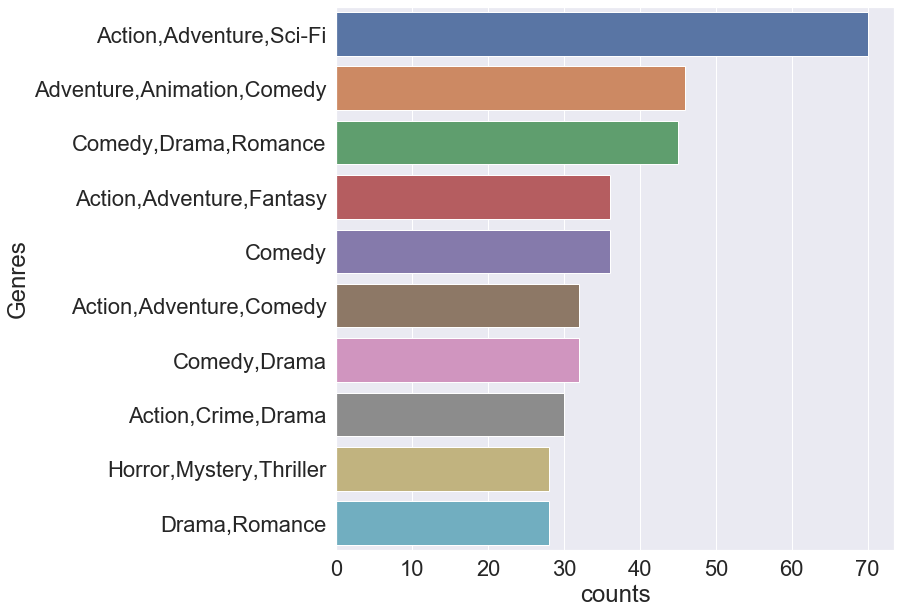

In [10]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.barplot(x='counts', y='Genres', data = top10genre,)

In [13]:
#WorldWide Gross vs. Genre
dummy_master = movie_master_df
unique_genres = []
worldwideGross_genre_dict = {}
for x in range(0,len(dummy_master)):
    if dummy_master.genreString[x] in worldwideGross_genre_dict:
        worldwideGross_genre_dict[dummy_master.genreString[x]] += dummy_master.Worldwide[x]
    else:
        unique_genres.append(dummy_master.genreString[x])
        worldwideGross_genre_dict[dummy_master.genreString[x]] = dummy_master.Worldwide[x]
print(len(unique_genres))
print(len(worldwideGross_genre_dict))
        

185
185


In [143]:
worldwideGross_genre_dict['Drama,Horror,Western']

382579

In [14]:
top20worldwide_genre_value_list = sorted(worldwideGross_genre_dict.values(), reverse=True)[:20]
top20worldwide_genre_value_list

[42731726805,
 26256089376,
 14926039789,
 11725789362,
 8214038921,
 7498317603,
 7453069220,
 7406110645,
 5364479842,
 5237807816,
 4407834044,
 3733232537,
 3441228963,
 2877353322,
 2843496652,
 2589016539,
 2460570093,
 2253793287,
 2189919016,
 2140948049]

In [15]:
top20worldwide_genre_key_list = sorted(worldwideGross_genre_dict, key=worldwideGross_genre_dict.__getitem__, reverse=True)[:20]
top20worldwide_genre_key_list

['Action,Adventure,Sci-Fi',
 'Adventure,Animation,Comedy',
 'Action,Adventure,Fantasy',
 'Action,Adventure,Comedy',
 'Adventure,Family,Fantasy',
 'Action,Adventure,Drama',
 'Action,Adventure,Thriller',
 'Action,Adventure,Animation',
 'Action,Adventure,Crime',
 'Comedy',
 'Adventure,Drama,Fantasy',
 'Horror,Mystery,Thriller',
 'Action,Comedy,Crime',
 'Comedy,Drama,Romance',
 'Comedy,Romance',
 'Drama,Romance',
 'Action,Thriller',
 'Comedy,Drama',
 'Crime,Drama,Thriller',
 'Biography,Drama,History']

In [16]:
top20Genre_Gross_df = pd.DataFrame(top20worldwide_genre_key_list, columns = ['Genres'])
top20Genre_Gross_df['WorldWide Gross($)'] = top20worldwide_genre_value_list
top20Genre_Gross_df

,Genres,WorldWide Gross($)
0,"Action,Adventure,Sci-Fi",42731726805
1,"Adventure,Animation,Comedy",26256089376
2,"Action,Adventure,Fantasy",14926039789
3,"Action,Adventure,Comedy",11725789362
4,"Adventure,Family,Fantasy",8214038921
5,"Action,Adventure,Drama",7498317603
6,"Action,Adventure,Thriller",7453069220
7,"Action,Adventure,Animation",7406110645
8,"Action,Adventure,Crime",5364479842
9,Comedy,5237807816


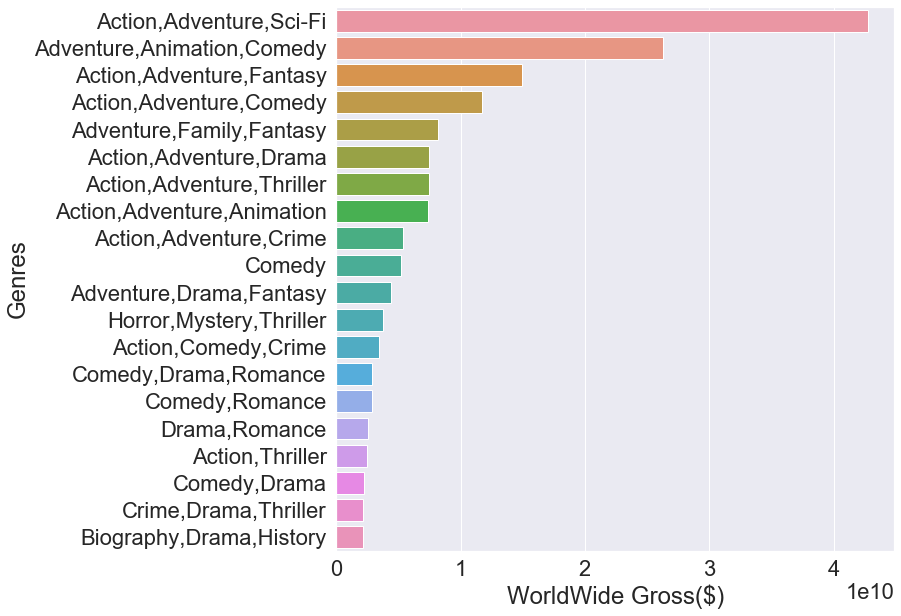

In [17]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.barplot(x='WorldWide Gross($)', y='Genres', data = top20Genre_Gross_df)

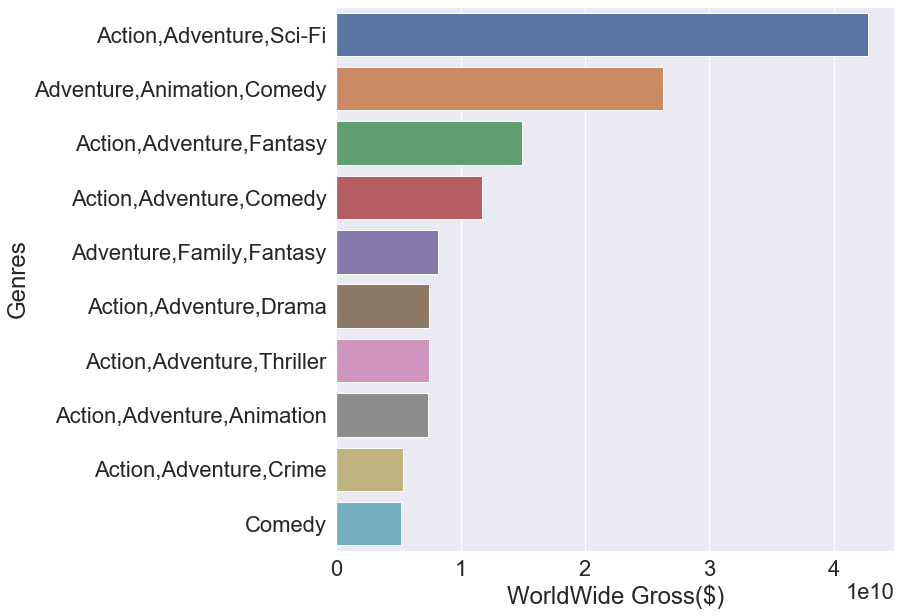

In [18]:
top10Genre_Gross_df = top20Genre_Gross_df.iloc[:10]
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.barplot(x='WorldWide Gross($)', y='Genres', data = top10Genre_Gross_df)

In [164]:
## Count vs. Gross
top20genre.set_index('Genres', inplace = True)
genre_Count_Gross_df = top20Genre_Gross_df.merge(top20genre, on = 'Genres')
genre_Count_Gross_df

,Genres,WorldWide Gross($),counts
0,"Action,Adventure,Sci-Fi",42731726805,70
1,"Adventure,Animation,Comedy",26256089376,46
2,"Action,Adventure,Fantasy",14926039789,36
3,"Action,Adventure,Comedy",11725789362,32
4,"Action,Adventure,Drama",7498317603,26
5,"Action,Adventure,Thriller",7453069220,19
6,Comedy,5237807816,36
7,"Horror,Mystery,Thriller",3733232537,28
8,"Action,Comedy,Crime",3441228963,22
9,"Comedy,Drama,Romance",2877353322,45


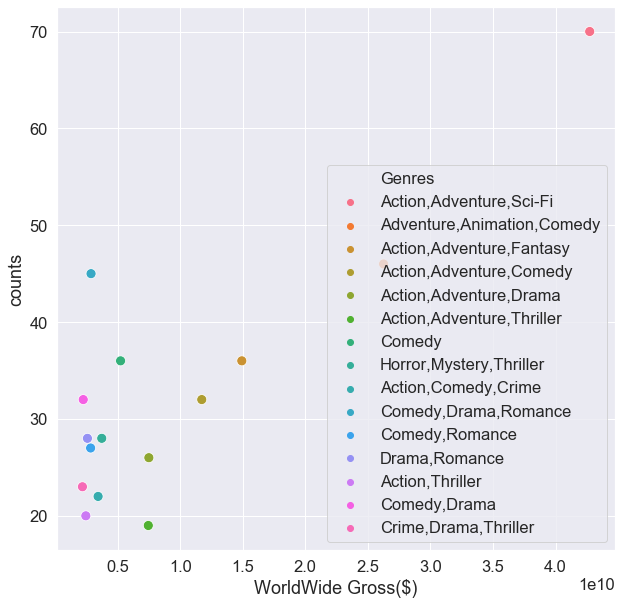

In [175]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='WorldWide Gross($)', y='counts', data = genre_Count_Gross_df, hue ='Genres', s = 100)

In [22]:
## Only way to accurate get statistics on each of the top 6 genres is to seperate them.
AcAdSc_df = movie_master_df[movie_master_df['genreString'] == 'Action,Adventure,Sci-Fi']
AdAnCo_df = movie_master_df[movie_master_df['genreString'] == 'Adventure,Animation,Comedy']
AcAdFan_df = movie_master_df[movie_master_df['genreString'] == 'Action,Adventure,Fantasy']
AcAdCo_df = movie_master_df[movie_master_df['genreString'] == 'Action,Adventure,Comedy']
AdFamFan_df = movie_master_df[movie_master_df['genreString'] == 'Action,Adventure,Drama']
AcAdThr_df = movie_master_df[movie_master_df['genreString'] == 'Action,Adventure,Thriller']


In [23]:
top6genre_df = movie_master_df[(movie_master_df['genreString'] == 'Action,Adventure,Sci-Fi') |
                              (movie_master_df['genreString'] == 'Adventure,Animation,Comedy') |
                              (movie_master_df['genreString'] == 'Action,Adventure,Fantasy') |
                              (movie_master_df['genreString'] == 'Action,Adventure,Comedy') |
                              (movie_master_df['genreString'] == 'Action,Adventure,Drama') |
                              (movie_master_df['genreString'] == 'Action,Adventure,Thriller')]
top6genre_df.head()

,tconst,Domestic,International,Worldwide,releaseMonth,movieTitle,releaseYear,genreString,averageRating,numVotes,nconst,releaseSeason
2,tt0369610,652270625,1018130012,1670400637,Jun,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,560294,['nm1119880'],Summer
4,tt0377981,99967670,94000000,193967670,Feb,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,50968,['nm0038432'],Winter
5,tt0398286,200821936,391639796,592461732,Nov,Tangled,2010,"Adventure,Animation,Comedy",7.7,388261,"['nm1977355', 'nm0397174']",Fall
6,tt0401729,73078100,211061000,284139100,Mar,John Carter,2012,"Action,Adventure,Sci-Fi",6.6,248965,['nm0004056'],Spring
9,tt0429493,77222099,100016697,177238796,Jun,The A-Team,2010,"Action,Adventure,Thriller",6.7,240992,['nm0138620'],Summer


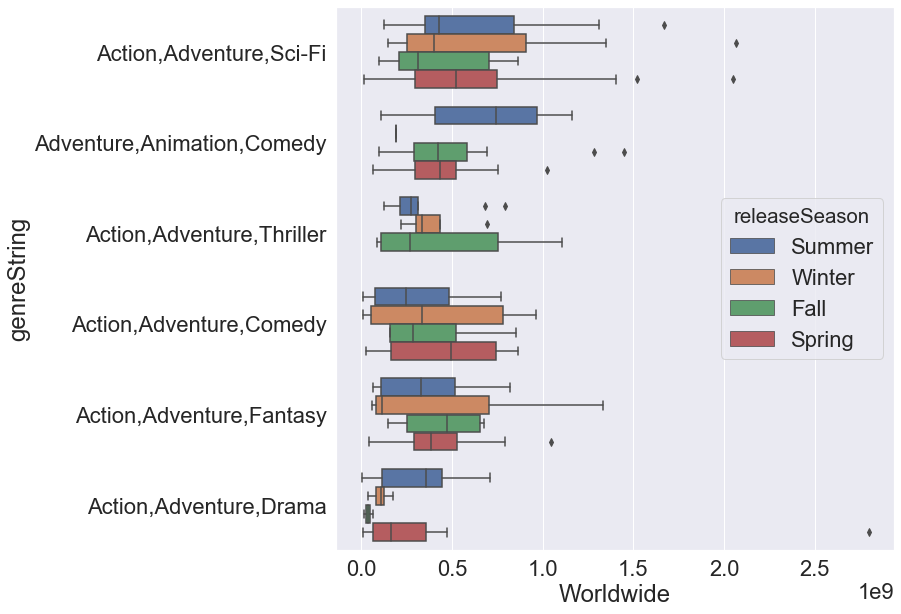

In [32]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.boxplot(x='Worldwide', y='genreString', hue ='releaseSeason', data = top6genre_df)

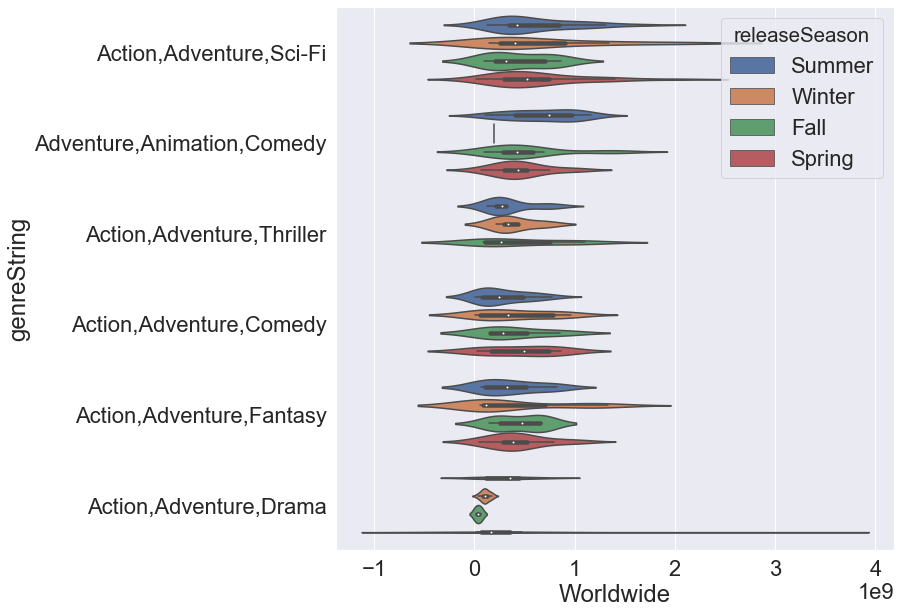

In [30]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.violinplot(x='Worldwide', y='genreString', hue='releaseSeason', data = top6genre_df)

In [31]:
top3genre_df = movie_master_df[(movie_master_df['genreString'] == 'Action,Adventure,Sci-Fi')|
                              (movie_master_df['genreString'] == 'Adventure,Animation,Comedy')|
                              (movie_master_df['genreString'] == 'Action,Adventure,Fantasy')]
top3genre_df.head()                              

,tconst,Domestic,International,Worldwide,releaseMonth,movieTitle,releaseYear,genreString,averageRating,numVotes,nconst,releaseSeason
2,tt0369610,652270625,1018130012,1670400637,Jun,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,560294,['nm1119880'],Summer
4,tt0377981,99967670,94000000,193967670,Feb,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,50968,['nm0038432'],Winter
5,tt0398286,200821936,391639796,592461732,Nov,Tangled,2010,"Adventure,Animation,Comedy",7.7,388261,"['nm1977355', 'nm0397174']",Fall
6,tt0401729,73078100,211061000,284139100,Mar,John Carter,2012,"Action,Adventure,Sci-Fi",6.6,248965,['nm0004056'],Spring
13,tt0435761,415004880,651964823,1066969703,Jun,Toy Story 3,2010,"Adventure,Animation,Comedy",8.3,726363,['nm0881279'],Summer


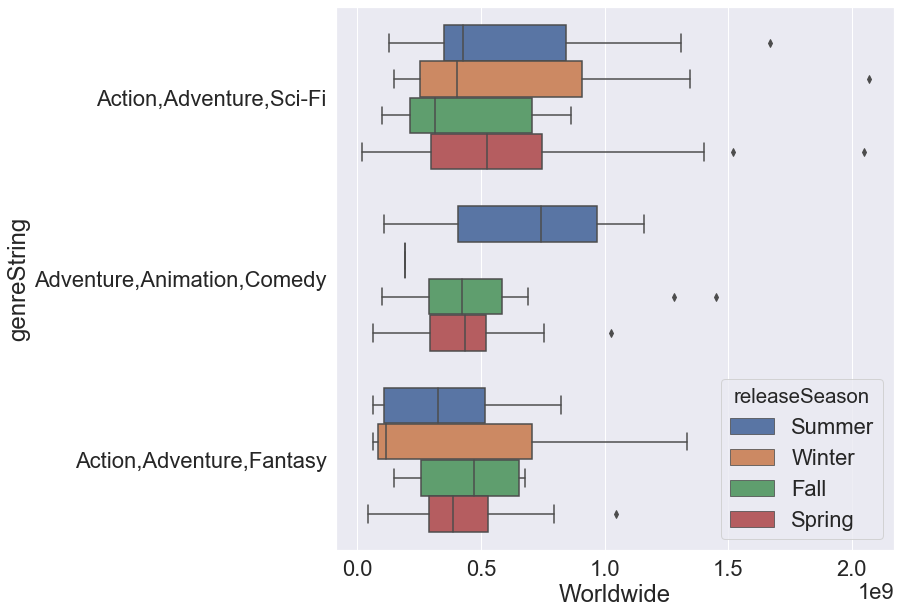

In [33]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.boxplot(x='Worldwide', y='genreString', hue ='releaseSeason', data = top3genre_df)

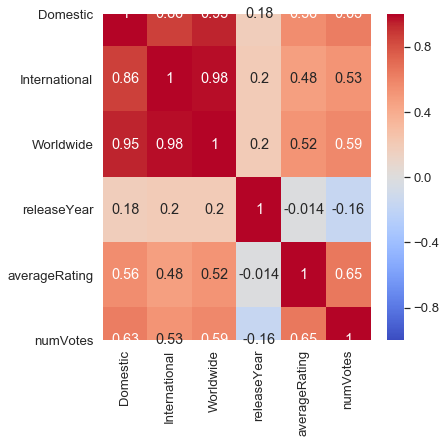

In [217]:
sns.set(font_scale=1.2)
plt.figure(figsize = (6,6))
sns.heatmap(top6genre_df.corr(),
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True);

<Figure size 720x720 with 0 Axes>

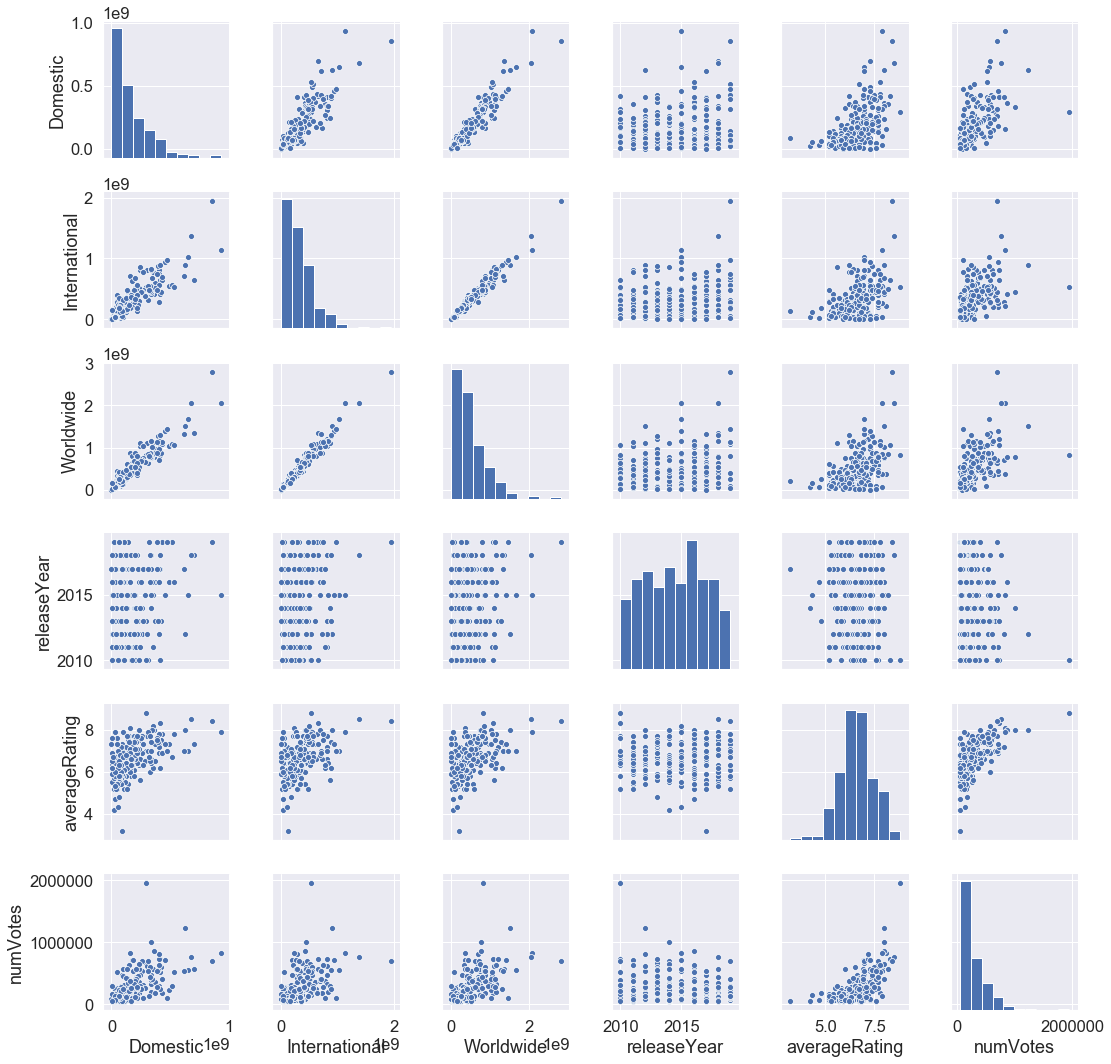

In [210]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.pairplot(top6genre_df)

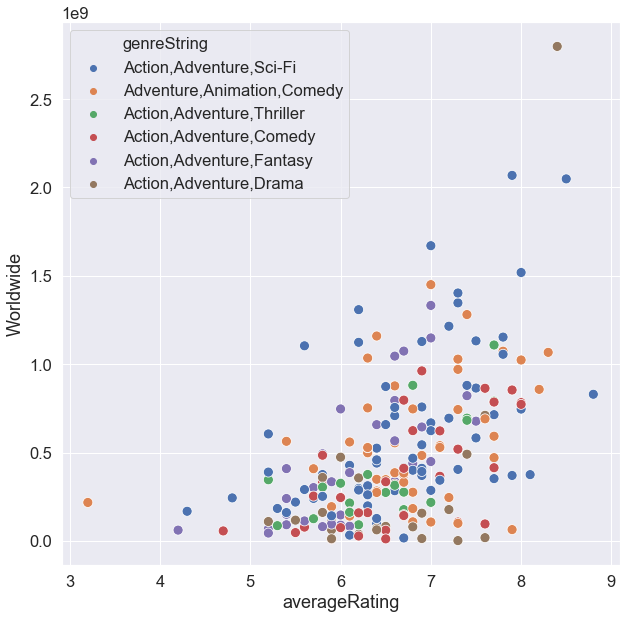

In [206]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='averageRating', y='Worldwide', data = top6genre_df, hue='genreString', s=100)

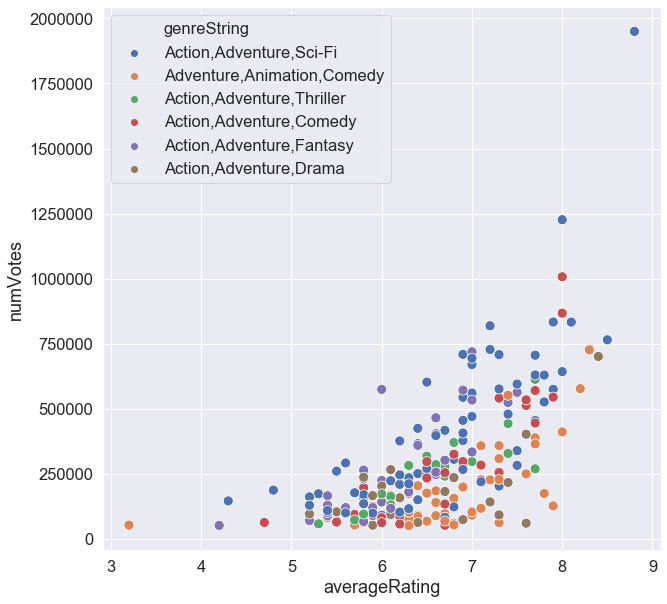

In [232]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='averageRating', y='numVotes', data = top6genre_df, hue='genreString', s=100)

In [207]:
AcAdSc_df.head()

,tconst,Domestic,International,Worldwide,releaseMonth,movieTitle,releaseYear,genreString,averageRating,numVotes,nconst,releaseSeason
2,tt0369610,652270625,1018130012,1670400637,Jun,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,560294,['nm1119880'],Summer
6,tt0401729,73078100,211061000,284139100,Mar,John Carter,2012,"Action,Adventure,Sci-Fi",6.6,248965,['nm0004056'],Spring
14,tt0437086,85710210,319142333,404852543,Feb,Alita: Battle Angel,2019,"Action,Adventure,Sci-Fi",7.3,202735,['nm0001675'],Winter
24,tt0458339,176654505,193915269,370569774,Jul,Captain America: The First Avenger,2011,"Action,Adventure,Sci-Fi",6.9,708801,['nm0002653'],Summer
45,tt0770828,291045518,377000000,668045518,Jun,Man of Steel,2013,"Action,Adventure,Sci-Fi",7.0,669738,['nm0811583'],Summer


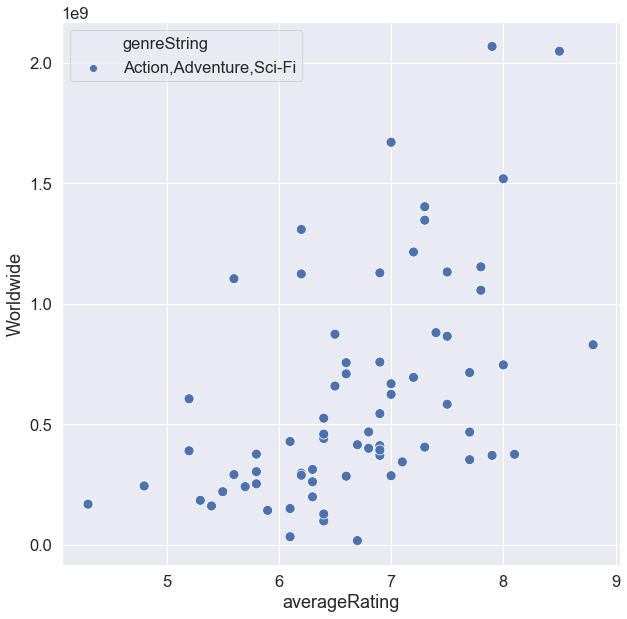

In [208]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='averageRating', y='Worldwide', data = AcAdSc_df, hue='genreString',s=100)

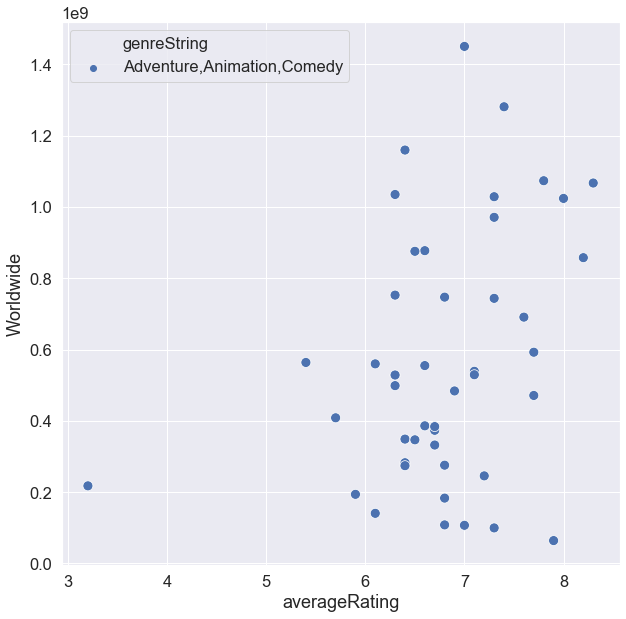

In [218]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='averageRating', y='Worldwide', data = AdAnCo_df, hue='genreString',s=100)

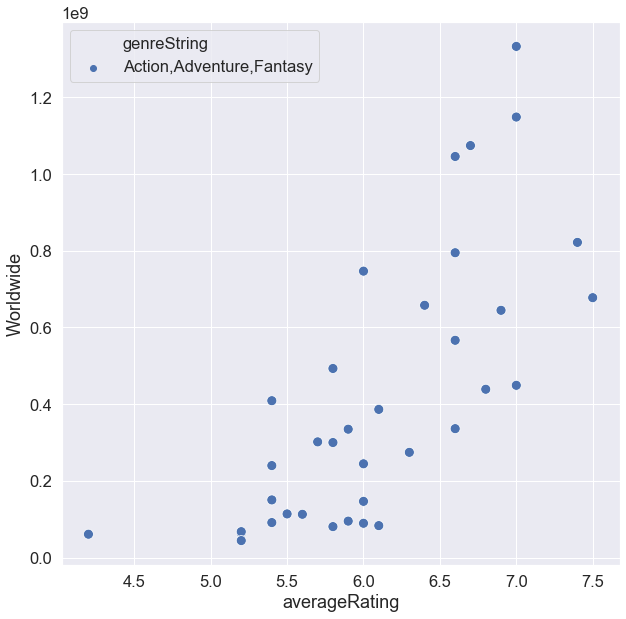

In [220]:
sns.set(font_scale=1.5)
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='averageRating', y='Worldwide', data = AcAdFan_df, hue='genreString',s=100)

- Revenue (y) vs. Top 10 Directors Boxplot
- Top 10 Director Gross Income vs. Movie Number

In [241]:
top6genre_df.set_index('nconst', inplace = True)
top6genre_df.reset_index(inplace = True)
top6genre_df.head()

,nconst,tconst,Domestic,International,Worldwide,releaseMonth,movieTitle,releaseYear,genreString,averageRating,numVotes,releaseSeason
0,['nm1119880'],tt0369610,652270625,1018130012,1670400637,Jun,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,560294,Summer
1,['nm0038432'],tt0377981,99967670,94000000,193967670,Feb,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,50968,Winter
2,"['nm1977355', 'nm0397174']",tt0398286,200821936,391639796,592461732,Nov,Tangled,2010,"Adventure,Animation,Comedy",7.7,388261,Fall
3,['nm0004056'],tt0401729,73078100,211061000,284139100,Mar,John Carter,2012,"Action,Adventure,Sci-Fi",6.6,248965,Spring
4,['nm0138620'],tt0429493,77222099,100016697,177238796,Jun,The A-Team,2010,"Action,Adventure,Thriller",6.7,240992,Summer


In [279]:
top6genre_df.nconst[1][1]

"'"

In [281]:
## Turns out my nconst have turned to mush...SO i'm just going to read back
## in the crew list and merge them on my tconst.
title_crew_df = pd.read_csv('IMDb_new_tsvs/title.crew.tsv', delimiter ='\t', encoding='UTF-8', low_memory=False)
title_crew_df.head()
top6genre_df.reset_index(inplace=True)

In [286]:
title_crew_df.drop(columns = 'writers',inplace=True)
title_crew_df.set_index('tconst', inplace =True)


In [287]:
title_crew_df.head()

,directors
tconst,
tt0000001,nm0005690
tt0000002,nm0721526
tt0000003,nm0721526
tt0000004,nm0721526
tt0000005,nm0005690


In [291]:
top6genre_lite_df = top6genre_df.drop(columns = ['Domestic','International',
                                                'releaseYear','releaseMonth',
                                                'averageRating','numVotes',
                                                'releaseSeason'])
top6genre_lite_df

,tconst,Worldwide,movieTitle,genreString
0,tt0369610,1670400637,Jurassic World,"Action,Adventure,Sci-Fi"
1,tt0377981,193967670,Gnomeo & Juliet,"Adventure,Animation,Comedy"
2,tt0398286,592461732,Tangled,"Adventure,Animation,Comedy"
3,tt0401729,284139100,John Carter,"Action,Adventure,Sci-Fi"
4,tt0429493,177238796,The A-Team,"Action,Adventure,Thriller"
...,...,...,...,...
224,tt6450804,261119292,Terminator: Dark Fate,"Action,Adventure,Sci-Fi"
225,tt6565702,252442974,X-Men: Dark Phoenix,"Action,Adventure,Sci-Fi"
226,tt6663582,75320680,The Spy Who Dumped Me,"Action,Adventure,Comedy"
227,tt6921996,158970776,Johnny English Strikes Again,"Action,Adventure,Comedy"


In [293]:
top6genre_lite_df = top6genre_lite_df.merge(title_crew_df, on = 'tconst')

In [295]:
top6genre_lite_df['directors'] = top6genre_lite_df['directors'].map(lambda text: text.split(','))
top6genre_lite_df

,tconst,Worldwide,movieTitle,genreString,directors
0,tt0369610,1670400637,Jurassic World,"Action,Adventure,Sci-Fi",[nm1119880]
1,tt0377981,193967670,Gnomeo & Juliet,"Adventure,Animation,Comedy",[nm0038432]
2,tt0398286,592461732,Tangled,"Adventure,Animation,Comedy","[nm1977355, nm0397174]"
3,tt0401729,284139100,John Carter,"Action,Adventure,Sci-Fi",[nm0004056]
4,tt0429493,177238796,The A-Team,"Action,Adventure,Thriller",[nm0138620]
...,...,...,...,...,...
224,tt6450804,261119292,Terminator: Dark Fate,"Action,Adventure,Sci-Fi",[nm1783265]
225,tt6565702,252442974,X-Men: Dark Phoenix,"Action,Adventure,Sci-Fi",[nm1334526]
226,tt6663582,75320680,The Spy Who Dumped Me,"Action,Adventure,Comedy",[nm2573005]
227,tt6921996,158970776,Johnny English Strikes Again,"Action,Adventure,Comedy",[nm1256143]


In [298]:
directors_money_dict = {}
directors_movie_dict = {}
for x in range(0,len(top6genre_lite_df)):
    for item in top6genre_lite_df.directors[x]:
        if item in directors_money_dict:
            directors_money_dict[item] += top6genre_lite_df.Worldwide[x]
            directors_movie_dict[item].append(top6genre_lite_df.Worldwide[x])
        else:
            directors_money_dict[item] = top6genre_lite_df.Worldwide[x]
            directors_movie_dict[item] = []
            directors_movie_dict[item].append(top6genre_lite_df.Worldwide[x])
print(len(directors_money_dict))
print(len(directors_movie_dict))

203
203


In [303]:
directors_money_dict
directors_top6gen_df = pd.DataFrame(list(directors_money_dict.items()),columns = ['nconst','Total Generated Gross ($)'])
directors_top6gen_df

,nconst,Total Generated Gross ($)
0,nm1119880,1670400637
1,nm0038432,193967670
2,nm1977355,592461732
3,nm0397174,1616245927
4,nm0004056,1312709989
...,...,...
198,nm1098493,304868961
199,nm1601882,529323962
200,nm1334526,252442974
201,nm2573005,75320680


In [302]:
directors_movie_dict
directors_top6gen_movie_df = pd.DataFrame(list(directors_movie_dict.items()),columns = ['nconst','Individual Movie Gross ($)'])
directors_top6gen_movie_df

,nconst,Individual Movie Gross ($)
0,nm1119880,[1670400637]
1,nm0038432,[193967670]
2,nm1977355,[592461732]
3,nm0397174,"[592461732, 1023784195]"
4,nm0004056,"[284139100, 1028570889]"
...,...,...
198,nm1098493,[304868961]
199,nm1601882,[529323962]
200,nm1334526,[252442974]
201,nm2573005,[75320680]


In [304]:
directors_top6gen_movie_df.set_index('nconst',inplace=True)
directors_top6gen_df = directors_top6gen_df.merge(directors_top6gen_movie_df, on = 'nconst')
directors_top6gen_df

,nconst,Total Generated Gross ($),Individual Movie Gross ($)
0,nm1119880,1670400637,[1670400637]
1,nm0038432,193967670,[193967670]
2,nm1977355,592461732,[592461732]
3,nm0397174,1616245927,"[592461732, 1023784195]"
4,nm0004056,1312709989,"[284139100, 1028570889]"
...,...,...,...
198,nm1098493,304868961,[304868961]
199,nm1601882,529323962,[529323962]
200,nm1334526,252442974,[252442974]
201,nm2573005,75320680,[75320680]


In [305]:
name_basics_df = pd.read_csv('IMDb_new_tsvs/name.basics.tsv', delimiter ='\t', encoding='UTF-8', low_memory = False)
name_basics_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0043044,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0038355,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0054452,tt0049189,tt0059956,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0072562,tt0077975,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0060827,tt0050986,tt0083922,tt0050976"


In [306]:
name_basics_df.drop(columns = ['birthYear','deathYear','primaryProfession','knownForTitles'], inplace=True)
name_basics_df.set_index('nconst',inplace=True)
name_basics_df.head()

,primaryName
nconst,
nm0000001,Fred Astaire
nm0000002,Lauren Bacall
nm0000003,Brigitte Bardot
nm0000004,John Belushi
nm0000005,Ingmar Bergman


In [307]:
directors_top6gen_df = directors_top6gen_df.merge(name_basics_df, on ='nconst')
directors_top6gen_df.head()

,nconst,Total Generated Gross ($),Individual Movie Gross ($),primaryName
0,nm1119880,1670400637,[1670400637],Colin Trevorrow
1,nm0038432,193967670,[193967670],Kelly Asbury
2,nm1977355,592461732,[592461732],Nathan Greno
3,nm0397174,1616245927,"[592461732, 1023784195]",Byron Howard
4,nm0004056,1312709989,"[284139100, 1028570889]",Andrew Stanton


In [310]:
directors_top6gen_df = directors_top6gen_df.sort_values(by = 'Total Generated Gross ($)', ascending = False)
directors_top6gen_df.set_index('primaryName',inplace=True)
directors_top6gen_df.reset_index(inplace=True)
directors_top6gen_df.head()

,primaryName,nconst,Total Generated Gross ($),Individual Movie Gross ($)
0,Joe Russo,nm0751648,6713878114,"[714421503, 1153296293, 2048359754, 2797800564]"
1,Anthony Russo,nm0751577,6713878114,"[714421503, 1153296293, 2048359754, 2797800564]"
2,J.J. Abrams,nm0009190,3609733118,"[467365246, 2068223624, 1074144248]"
3,Pierre Coffin,nm1853544,3164963811,"[970766005, 1159398397, 1034799409]"
4,Joss Whedon,nm0923736,2921618856,"[1518812988, 1402805868]"


In [311]:
top20directors_top6genres = directors_top6gen_df.iloc[:20]
top10directors_top6genres = directors_top6gen_df.iloc[:10]
top10directors_top6genres

,primaryName,nconst,Total Generated Gross ($),Individual Movie Gross ($)
0,Joe Russo,nm0751648,6713878114,"[714421503, 1153296293, 2048359754, 2797800564]"
1,Anthony Russo,nm0751577,6713878114,"[714421503, 1153296293, 2048359754, 2797800564]"
2,J.J. Abrams,nm0009190,3609733118,"[467365246, 2068223624, 1074144248]"
3,Pierre Coffin,nm1853544,3164963811,"[970766005, 1159398397, 1034799409]"
4,Joss Whedon,nm0923736,2921618856,"[1518812988, 1402805868]"
5,Michael Bay,nm0000881,2833273308,"[1123794079, 1104054072, 605425157]"
6,Chris Buck,nm0118333,2730829215,"[1280802282, 1450026933]"
7,Jennifer Lee,nm1601644,2730829215,"[1280802282, 1450026933]"
8,Kyle Balda,nm0049633,2543038122,"[348840316, 1159398397, 1034799409]"
9,Zack Snyder,nm0811583,2289397234,"[668045518, 657924295, 89792502, 873634919]"


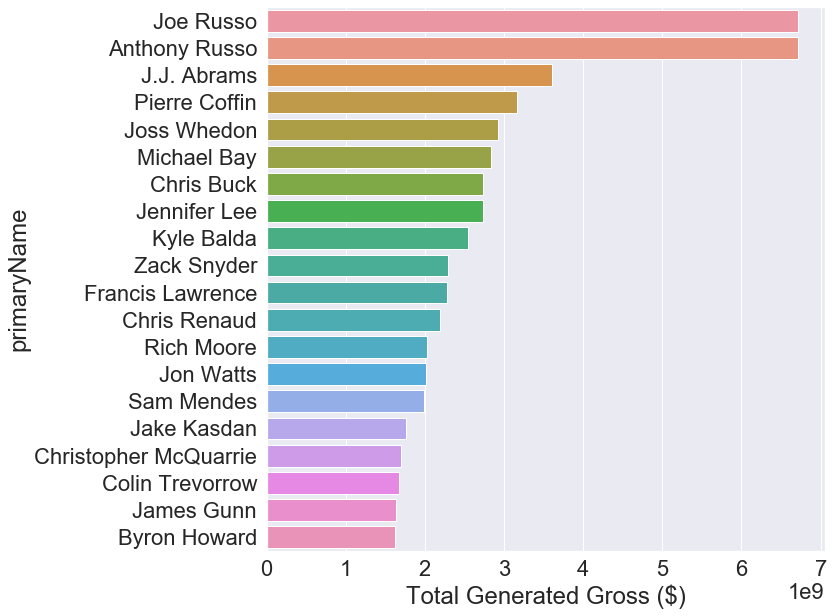

In [316]:
sns.set(font_scale=2)
plt.figure(figsize = (10,10))
ax = sns.barplot(y='primaryName', x='Total Generated Gross ($)', 
                 data = top20directors_top6genres)

- Top 3 Genre Gross Revenue vs. Season barchart (+ stddev error bars)

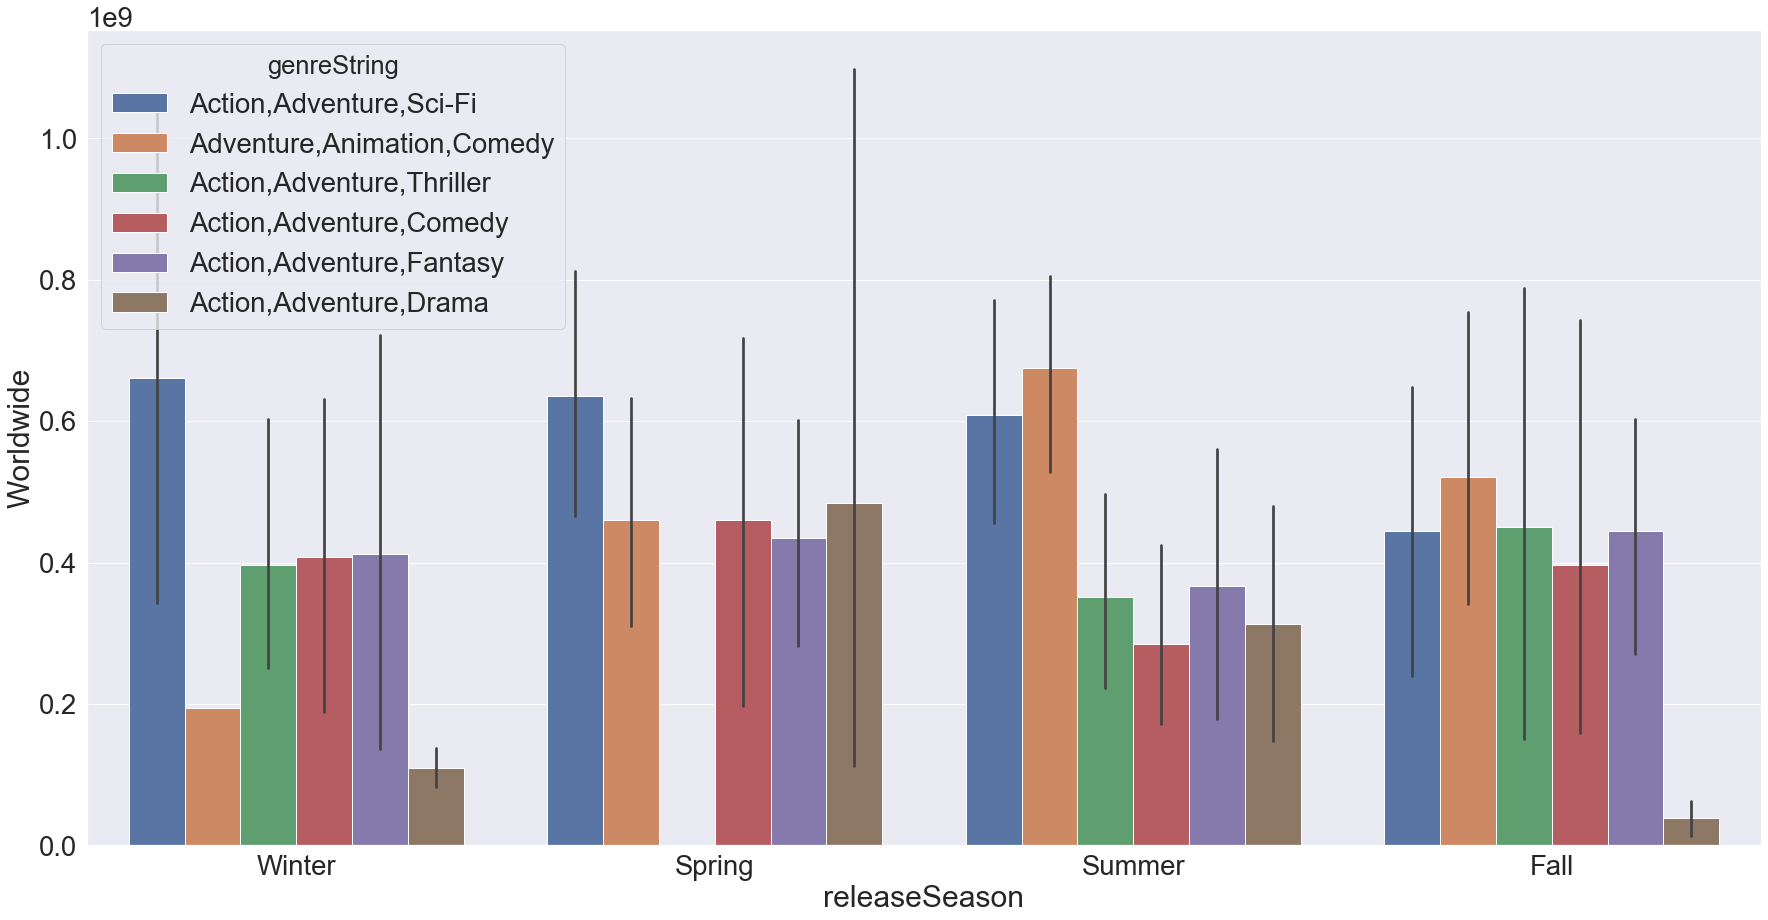

In [230]:
sns.set(font_scale=2.5)
plt.figure(figsize = (30,15))
ax = sns.barplot(x='releaseSeason', y='Worldwide', data = top6genre_df, hue = 'genreString', order = ['Winter','Spring','Summer','Fall'])

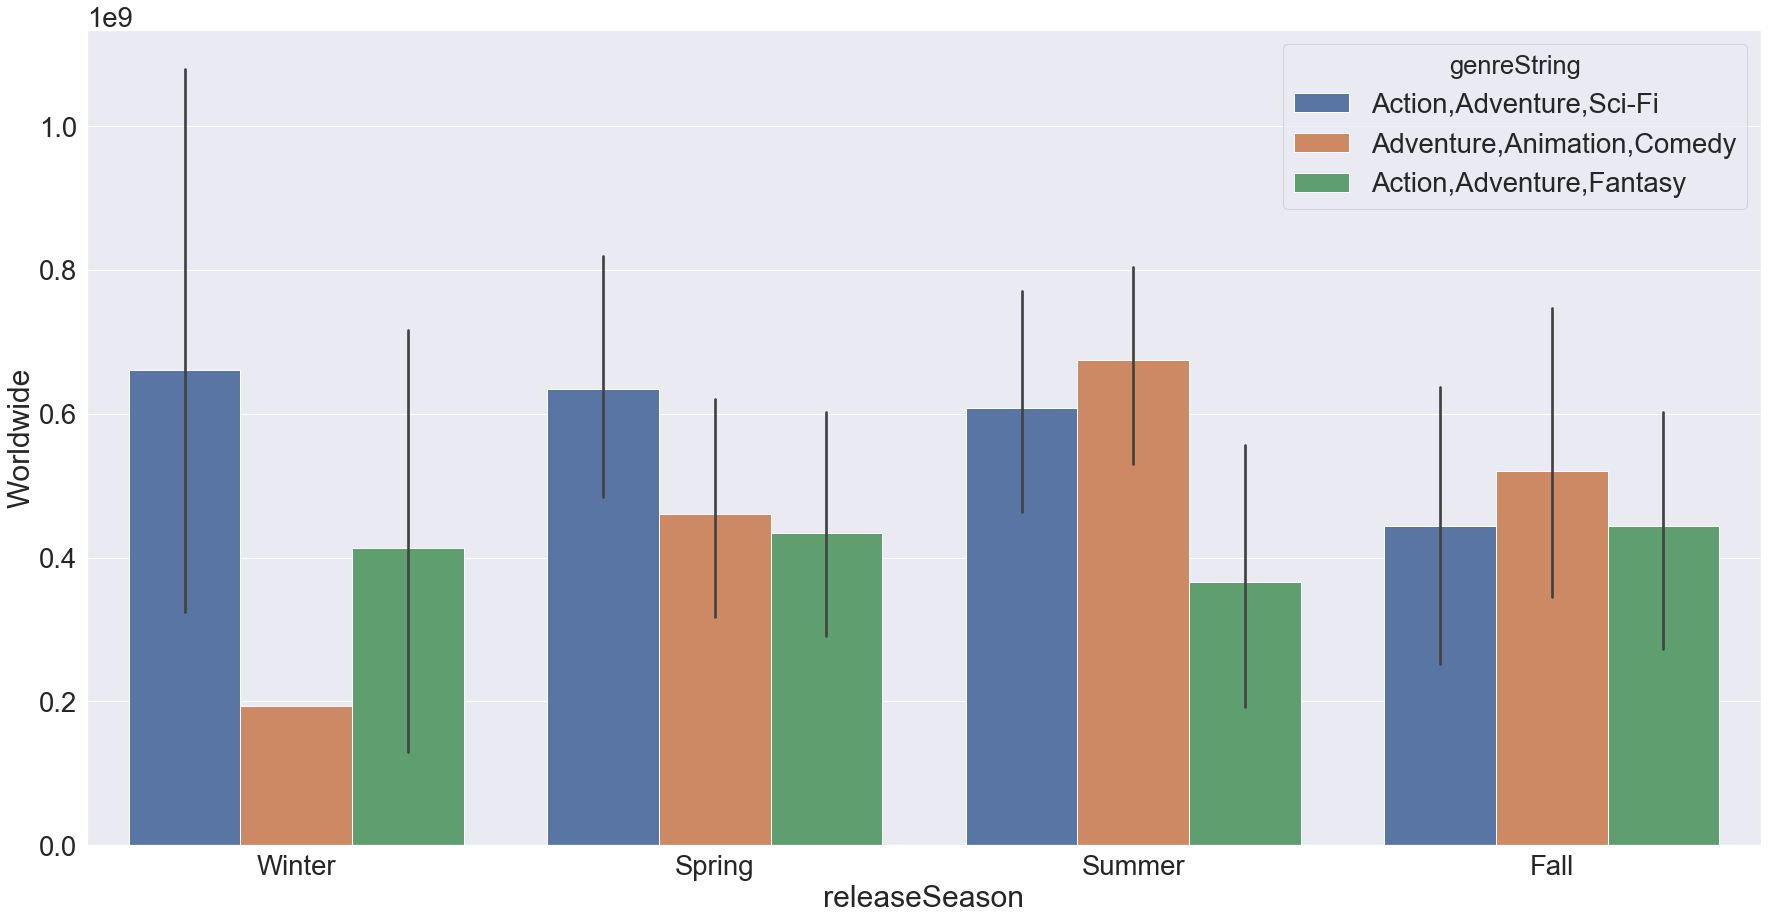

In [231]:
sns.set(font_scale=2.5)
plt.figure(figsize = (30,15))
ax = sns.barplot(x='releaseSeason', y='Worldwide', data = top3genre_df, hue = 'genreString',order = ['Winter','Spring','Summer','Fall'])

In [317]:
ls

Building Notebook.ipynb
CONTRIBUTING.md
Dummy Notebook.ipynb
IMBd TSV Work.ipynb
IMDb_2010_19_top50kVotes_w_financials.csv
IMDb_director_info_2010_2019.csv
IMDb_movie_info_2010_2019.csv
IMDb_new_tsvs/
LICENSE.md
README.md
Scraping Notebook.ipynb
awesome.gif
module1_project_rubric.pdf
movielens dataset-25m/
student.ipynb
top20MovieDistributors.tsv
unzippedData/
zippedData/


In [319]:
movie_distributors_df = pd.read_csv('top20MovieDistributors.tsv', delimiter ='\t')
movie_distributors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Rank                20 non-null int64
Distributor         20 non-null object
Movies              20 non-null int64
Total Box Office    20 non-null object
Tickets             20 non-null object
Share               20 non-null object
Unnamed: 6          0 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.2+ KB


In [ ]:
(16.94%)

In [323]:
movie_distributors_df['Total Box Office'] = movie_distributors_df['Total Box Office'].map(lambda text: int(text.replace('$','').replace(',','')))
movie_distributors_df['Tickets'] = movie_distributors_df['Tickets'].map(lambda text: int(text.replace(',','')))
movie_distributors_df['Share'] = movie_distributors_df['Share'].map(lambda text: float(text.replace('%','')))

In [324]:
movie_distributors_df.drop(columns=['Rank', 'Unnamed: 6'], inplace =True)
movie_distributors_df

,Distributor,Movies,Total Box Office,Tickets,Share
0,Walt Disney,571,39688247167,5668000685,16.94
1,Warner Bros.,802,35592155457,5128007400,15.19
2,Sony Pictures,728,28777646671,4258806679,12.28
3,Universal,511,27464279056,3938555708,11.72
4,20th Century Fox,519,25853240689,3792196830,11.04
5,Paramount Pictures,481,24231319306,3647168888,10.34
6,Lionsgate,415,9537881421,1211552593,4.07
7,New Line,207,6194343024,1116305898,2.64
8,Dreamworks SKG,77,4278649271,760431349,1.83
9,Miramax,384,3835978908,714099626,1.64


In [1]:
sns.set(font_scale=2)
plt.figure(figsize = (20,10))
ax = sns.barplot(y='Distributor', x='Share', 
                 data = movie_distributors_df)

NameError: name 'sns' is not defined